In [1]:
import numpy as np
import yaml
import matplotlib.pyplot as plt

#Import hardware classes
from pyRTC.hardware.OOPAOInterface import OOPAOInterface
from pyRTC.SlopesProcess import SlopesProcess
from pyRTC.Pipeline import *
from pyRTC.Loop import Loop
# from pyRTC.hardware.LoopGymInterface import LoopGymInterface

import gymnasium
import time



     °          *      *      
 ▄██▄   ▄██▄  ▄███▄   ▄██▄ * ▄██▄ 
██* ██ ██  ██ ██  ██ ██  ██ ██  ██
██  ██ ██° ██ ██  ██ ██* ██ ██  ██
██  ██ ██  ██ ████▀  ██▄▄██ ██  ██
██* ██ ██  ██ ██     ██▀▀██ ██  ██
██  ██ ██  ██ ██ *   ██  ██ ██* ██
 ▀██▀   ▀██▀  ██   ° ██  ██  ▀██▀ 
      *         *             


**************************************************************************************************************************************************************
NUMPY WARNING: mkl blas not found! Multi-threading may not work as expected.
**************************************************************************************************************************************************************


In [2]:
"""
Shared memory in python is a bit annoying, we are required to unlink it from the garbage collector
so that it will stick around in between runs, however sometime you can get into a situation where 
the SHM is not intialized properly. Usually you will see an error like: 
TypeError: buffer is too small for requested array

To reset a SHM you can run the following code. Note: it will throw some garbage collector errors.
"""
# shm_names = ["wfs", "wfsRaw", "wfc", "wfc2D", "signal", "signal2D", "psfShort", "psfLong"] #list of SHMs to reset
# clear_shms(shm_names)

'\nShared memory in python is a bit annoying, we are required to unlink it from the garbage collector\nso that it will stick around in between runs, however sometime you can get into a situation where \nthe SHM is not intialized properly. Usually you will see an error like: \nTypeError: buffer is too small for requested array\n\nTo reset a SHM you can run the following code. Note: it will throw some garbage collector errors.\n'

In [3]:
# Load the configuration file
def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        conf = yaml.safe_load(file)
    return conf

#Now we can read our YAML config file 
conf = read_yaml_file("simple_OOPAO_config.yaml")

#And separate it into sections for each of our AO loop components
confLoop = conf["loop"]
confWFS = conf["wfs"]
confWFC = conf["wfc"]
confPSF = conf["psf"]
confSlopes = conf["slopes"]

print(confLoop)
print(confWFS)
print(confWFC)
print(confPSF)
print(confSlopes)

{'gain': 0.1, 'numDroppedModes': 0, 'pokeAmp': 1e-06, 'numItersIM': 10, 'affinity': 2, 'method': 'push-pull', 'IMFile': 'simpleIM.npy', 'functions': ['standardIntegrator']}
{'name': 'OOPAOWFS', 'width': 32, 'height': 32, 'darkCount': 10, 'affinity': 3, 'functions': ['expose']}
{'name': 'OOPAOWFC', 'numActuators': 21, 'numModes': 18, 'flatFile': '', 'saveFile': 'flat.npy', 'm2cFile': '', 'affinity': 3, 'commandCap': 0.8, 'hardwareDelay': 0.1, 'frameDelay': 0, 'functions': ['sendToHardware']}
{'name': 'OOPAOPSF', 'index': 0, 'width': 160, 'height': 160, 'darkCount': 1000, 'integration': 100, 'affinity': 3, 'functions': ['expose']}
{'type': 'SHWFS', 'signalType': 'slopes', 'affinity': 4, 'refSlopesFile': '', 'validSubApsFile': '', 'subApSpacing': 8, 'subApOffsetX': 0, 'subApOffsetY': 0, 'functions': ['computeSignal']}


In [4]:
from simpleParamFile import *
param = initializeParameterFile()

Reading/Writting calibration data from data_calibration/
Writting output data in data_cl/


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             1                [m]        
    Resolution            32             [pixels]     
    Pixel Size           0.03              [m]        
     Surface             1.0               [m2]       
Central Obstruction       0.0         [% of diameter]  
Pixels in the pupil       812             [pixels]     
      Source             None                         
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
No light propagated through the telescope
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             1                [m]        
    Resolution            32             [pixels]     
    Pixel Size           0.03              [m]        
     Surface             1.0               [m2]       
Central Obstruction       0.0         [% of diameter]  
Pixels in the pupil       812             [pixels]     
      Source         

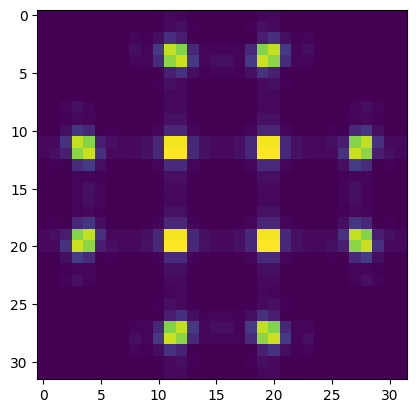

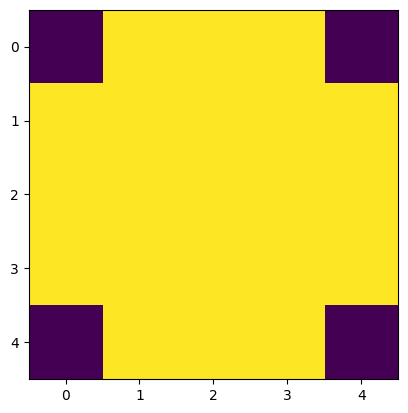

NUM VALID ACT: 21


In [5]:
"""
Create the OOPAO simulation interface object 
Running this cell will initialize the dm, wfs, psf, and slopes objects, 
but will not start their real time computations. This inialization includes
the creation of the Shared Memory Objects, and the simulation inialization.
"""
sim = OOPAOInterface(conf=conf, param=param)
wfs, dm, psf = sim.get_hardware()

plt.imshow(wfs.wfs.cam.frame)
plt.show()

plt.imshow(dm.layout)
plt.show()

print(f"NUM VALID ACT: {np.sum(dm.layout)}")

In [6]:
"""
It's important to set the full basis and number of possible modes before
initializing the loop object. Here I define a KL basis for the system
"""
from OOPAO.calibration.compute_KL_modal_basis import compute_KL_basis

NUM_MODES = 18

M2C_KL = compute_KL_basis(sim.tel, sim.atm, sim.dm)
dm.setM2C(M2C_KL[:,:NUM_MODES])

"""
"""
slopes = SlopesProcess(conf=conf)

""" 
"""
#Initialize our AO loop object
loop = Loop(conf=conf)

TIME ELAPSED: 0 sec. COMPLETED: 100 %
NMAX =  17
RMS opd error = [[1.69814834e-08 6.46646817e-08 6.46646817e-08]]
RMS Positions = [[1.75602688e-07 5.60200196e-07 5.60200196e-07]]
MAX Positions = [[6.19665037e-07 9.99272119e-07 9.99272119e-07]]
KL WITH DOUBLE DIAGONALISATION: COVARIANCE ERROR =  3.58125053213961e-14
Closing wfc
Opening Existing Shared Memory Object wfc
Opening Existing Shared Memory Object wfc_meta
Opening Existing Shared Memory Object wfs_meta
Closing wfs_meta
Opening Existing Shared Memory Object wfs
Opening Existing Shared Memory Object wfs_meta
subApSpacing: 8
numRegions: 4
offsetX: 0
offsetY: 0
signalSize: 32
signalShape: (32,)
signalDType: <class 'numpy.float32'>
Opening Existing Shared Memory Object signal
Opening Existing Shared Memory Object signal_meta
Opening Existing Shared Memory Object signal2D
Opening Existing Shared Memory Object signal2D_meta
Opening Existing Shared Memory Object signal_meta
Closing signal_meta
Opening Existing Shared Memory Object sign

In [7]:
"""
Start the processes. Here the real-time computations selected in
the config will begin.
"""
dm.start()
dm.flatten()

wfs.start()
slopes.start()

#Take new reference slopes while dm is flat.
# time.sleep(1)
# slopes.takeRefSlopes()

print(sim.dm.OPD.shape)
psf.start()

(32, 32, 21)


In [8]:
sim.addAtmosphere()

Telescope and Atmosphere combined!
Telescope and Atmosphere combined!


In [9]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces


class CustomEnv(gym.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, loop, render_mode=None, buffer=0):
        super().__init__()
        self.loop = loop
        self.buffer = buffer
        self.render_mode = render_mode
        self.default_action = np.zeros(self.loop.confWFC['numModes'], dtype=np.float32)
        self.flat2D = self.flat2D = np.zeros((self.loop.wfc2D_width, self.loop.wfc2D_height))
        self.active_modes = self.loop.numActiveModes
    
        self.slope_norm = 10
        self.cmd_norm = 1e-7
        self.timestep_limit = 1e10
        self.current_step = 0
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        
        # Example for using image as input (channel-first; channel-last also works):
        self.observation_space = spaces.Dict(
            {
                "slopes": spaces.Box(low=-1, high=1,
                                            shape=(self.loop.slopes_width, self.loop.slopes_height), dtype=np.float32),
                "command": spaces.Box(low=-1, high=1,
                                            shape=(self.loop.wfc2D_width, self.loop.wfc2D_height), dtype=np.float32)
            }
        )
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.loop.confWFC["numModes"], ) , dtype=np.float32)


    def _get_obs(self):
        """A private method to build an observation from a state"""


        self._normalized_cmd2D = self._cmd2D_obs / self.cmd_norm

        self._normalized_slopes = self._slopes_obs / self.slope_norm

        return {"slopes": self._normalized_slopes, "command": self._normalized_cmd2D}
    
    
    def _get_info(self):
        return {
            'TimeLimit.truncated': False
        }
    

    def _send_control(self, control):

        control[self.active_modes:] = 0

        self.control = control * self.cmd_norm
        
        self.loop.wfcShm.write(self.control)


    def step(self, action):
        self.current_step += 1

        #send the command to the mirror
        self._send_control(action)

        # make a blocking read of the wfc to make sure the action has been set
        self._cmd2D_obs = self.loop.wfc2DShm.read()

        # read the slopes
        self._slopes_obs = self.loop.slopesShm.read()

        observation = self._get_obs()

        # Compute reward
        reward = np.exp(-np.var(self._slopes_obs), dtype=np.float32).item()

        #Terminated condition -> divergent slopes
        terminated = bool(reward < np.exp(-9))

        # Info + Truncation
        if self.current_step >= self.timestep_limit:
            truncated = True
            info = {'TimeLimit.truncated': True}
        else:
            truncated = False
            info = {'TimeLimit.truncated': False}

        
        return observation, reward, terminated, truncated, info


    def reset(self, seed=None, options=None):
        self.current_step = 0

        #Flatten the mirror
        self._send_control(self.default_action)

        # Sleep to make sure the blocking order is reset
        time.sleep(0.01)

        #Set the current command
        self._cmd2D_obs = self.loop.wfc2DShm.read()

        #Read the slopes
        self._slopes_obs = self.loop.slopesShm.read()

        #Build the observation
        observation = self._get_obs()

        # Get info dict
        info = self._get_info()

    
        return observation, info


    def render(self):
        if self.render_mode == None:
            return

    def close(self):
        return

In [10]:
# from pyRTC.hardware.GymEnv import CustomEnv

env = CustomEnv(loop=loop)

In [ ]:
env.reset()

for i in range(1000):
    obs, reward, *_ = env.step(env.action_space.sample())

env.reset()

In [ ]:
env.reset()

obs, *_ = env.step(env.action_space.sample())

plt.imshow(obs['slopes'])
plt.show()

In [ ]:
from stable_baselines3.common import env_checker

env_checker.check_env(env, warn=True, skip_render_check=True)

In [30]:
import gymnasium as gym
import torch as th
from torch import nn

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from typing import Callable, Dict, List, Optional, Tuple, Type, Union

from gymnasium import spaces
from stable_baselines3.common.policies import ActorCriticPolicy


class CustomCombinedExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Dict):
        # We do not know features-dim here before going over all the items,
        # so put something dummy for now. PyTorch requires calling
        # nn.Module.__init__ before adding modules
        super().__init__(observation_space, features_dim=1)

        self._numFeatures = 32

        self.cnn = nn.Sequential(
                                nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding='same'),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='valid'),
                                nn.ReLU(),
                                nn.Flatten())
        

        # find the output size of the CNN for each obs
        n_flatten = {}

        with th.no_grad():
            for key, subspace in observation_space.spaces.items():
                # print(observation_space.sample()[key].shape)
                n_flatten[key] = self.cnn(
                    th.as_tensor(observation_space.sample()[key][np.newaxis,np.newaxis,:,:]).float()
                ).shape[1]

        
        # with th.no_grad():
        #     for key, subspace in observation_space.spaces.items():

        #         sample = observation_space.sample()[key][np.newaxis,np.newaxis,:,:]

        #         n_flatten[key] = self._get_conv_output(sample.shape)

        

               

        # print(n_flatten)        

    
        extractors = {}

        # We need to know size of the output of this extractor,
        # so go over all the spaces and compute output feature sizes
        for key, subspace in observation_space.spaces.items():
            if key == "slopes":
                # We will just downsample one channel of the image by 4x4 and flatten.
                # Assume the image is single-channel (subspace.shape[0] == 0)
                extractors[key] = nn.Sequential(self.cnn,
                                nn.Linear(n_flatten[key], self._numFeatures),
                                nn.ReLU(),
                                nn.Flatten())
                
            elif key == "command":
                # Run through a simple MLP
                extractors[key] = nn.Sequential(self.cnn,
                                nn.Linear(n_flatten[key], self._numFeatures),
                                nn.ReLU(),
                                nn.Flatten())

        self.extractors = nn.ModuleDict(extractors)

        # Update the features dim manually
        self._features_dim = 64

    def forward(self, observations) -> th.Tensor:
        encoded_tensor_list = []

        # self.extractors contain nn.Modules that do all the processing.
        for key, extractor in self.extractors.items():
            # print(th.Tensor(observations[key][:, np.newaxis, :, :]).shape)
            # print(extractor(th.Tensor(observations[key][:, np.newaxis,:, :])).shape)
            feature = extractor(th.Tensor(observations[key][:, np.newaxis, :, :]))

            feature = feature.reshape(feature.shape[0], -1)

            encoded_tensor_list.append(feature)
        # Return a (B, self._features_dim) PyTorch tensor, where B is batch dimension.
        return th.cat(encoded_tensor_list, dim=1)


    def _get_conv_output(self, shape):
        # Helper function to calculate the size of the flattened features after conv layers
            with th.no_grad():
                input = th.rand(1, *shape)
                output = self.cnn(input)
                return int(th.prod(th.tensor(output.size()[1:])))

In [25]:
class CustomNetwork(nn.Module):
    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 64,
        last_layer_dim_vf: int = 64,
        hidden_size: int = 128,  # LSTM hidden layer size
    ):
        super().__init__()
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

        # LSTM layer
        self.lstm = nn.LSTM(input_size=feature_dim, hidden_size=hidden_size, batch_first=True)

        # Policy network
        self.policy_net = nn.Sequential(
            nn.Linear(hidden_size, last_layer_dim_pi), nn.ReLU()
        )
        # Value network
        self.value_net = nn.Sequential(
            nn.Linear(hidden_size, last_layer_dim_vf), nn.ReLU()
        )

    def forward(self, features: th.Tensor, hx=None) -> Tuple[th.Tensor, th.Tensor, th.Tensor]:
        features = features.unsqueeze(1)  # Add sequence dimension (batch, sequence, feature)
        if hx is None:
            lstm_out, hx = self.lstm(features)
        else:
            lstm_out, hx = self.lstm(features, hx)
        lstm_out = lstm_out.squeeze(1)  # Remove the sequence dimension
        return self.forward_actor(lstm_out), self.forward_critic(lstm_out), hx

    def forward_actor(self, features: th.Tensor) -> th.Tensor:
        return self.policy_net(features)

    def forward_critic(self, features: th.Tensor) -> th.Tensor:
        return self.value_net(features)

In [26]:
from stable_baselines3.common.type_aliases import PyTorchObs, Schedule
from stable_baselines3.common.distributions import (
    BernoulliDistribution,
    CategoricalDistribution,
    DiagGaussianDistribution,
    Distribution,
    MultiCategoricalDistribution,
    StateDependentNoiseDistribution,
    make_proba_distribution,
)

class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        lr_schedule: Callable[[float], float],
        *args,
        **kwargs,
    ):
        kwargs["ortho_init"] = False  # Disable orthogonal initialization
        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            *args,
            **kwargs,
        )
        self.hidden_state = None

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetwork(self.features_dim)

    

    def forward(self, obs: th.Tensor, deterministic: bool = False) -> Tuple[th.Tensor, th.Tensor, th.Tensor]:
        """
        Forward pass in all the networks (actor and critic)

        :param obs: Observation
        :param deterministic: Whether to sample or use deterministic actions
        :return: action, value and log probability of the action
        """
        # Preprocess the observation if needed
        features = self.extract_features(obs)
        hx_in = self.hidden_state
        
        if self.share_features_extractor:
            latent_pi, latent_vf, hx_out = self.mlp_extractor(features, hx_in)
            self.hidden_state = hx_out
        else:
            pi_features, vf_features = features
            latent_pi = self.mlp_extractor.forward_actor(pi_features)
            latent_vf = self.mlp_extractor.forward_critic(vf_features)
        # Evaluate the values for the given observations
        values = self.value_net(latent_vf)
        distribution = self._get_action_dist_from_latent(latent_pi)
        actions = distribution.get_actions(deterministic=deterministic)
        log_prob = distribution.log_prob(actions)
        actions = actions.reshape((-1, *self.action_space.shape))  # type: ignore[misc]
        return actions, values, log_prob

    def predict_values(self, obs: PyTorchObs) -> th.Tensor:
        """
        Get the estimated values according to the current policy given the observations.

        :param obs: Observation
        :return: the estimated values.
        """
        features = super().extract_features(obs, self.vf_features_extractor)
        _, latent_vf, _ = self.mlp_extractor.forward(features, self.hidden_state)
        return self.value_net(latent_vf)
    
    def evaluate_actions(self, obs: PyTorchObs, actions: th.Tensor) -> Tuple[th.Tensor, th.Tensor, Optional[th.Tensor]]:
        """
        Evaluate actions according to the current policy,
        given the observations.

        :param obs: Observation
        :param actions: Actions
        :return: estimated value, log likelihood of taking those actions
            and entropy of the action distribution.
        """
        # Preprocess the observation if needed
        features = self.extract_features(obs)
        if self.share_features_extractor:
            latent_pi, latent_vf, _ = self.mlp_extractor(features)
        else:
            pi_features, vf_features = features
            latent_pi = self.mlp_extractor.forward_actor(pi_features)
            latent_vf = self.mlp_extractor.forward_critic(vf_features)
        distribution = self._get_action_dist_from_latent(latent_pi)
        log_prob = distribution.log_prob(actions)
        values = self.value_net(latent_vf)
        entropy = distribution.entropy()
        return values, log_prob, entropy

    def get_distribution(self, obs: PyTorchObs) -> Distribution:
        """
        Get the current policy distribution given the observations.

        :param obs:
        :return: the action distribution.
        """
        features = super().extract_features(obs, self.pi_features_extractor)
        latent_pi, *_ = self.mlp_extractor.forward(features)
        return self._get_action_dist_from_latent(latent_pi)



    def reset_lstm_state(self):
        self.hidden_state = None


In [27]:
from stable_baselines3 import PPO
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.buffers import DictRolloutBuffer, RolloutBuffer
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback, Schedule
from stable_baselines3.common.utils import obs_as_tensor, safe_mean
from stable_baselines3.common.vec_env import VecEnv

class CustomPPO(PPO):

    def collect_rollouts(
            self,
            env: VecEnv,
            callback: BaseCallback,
            rollout_buffer: RolloutBuffer,
            n_rollout_steps: int,
        ) -> bool:
            """
            Collect experiences using the current policy and fill a ``RolloutBuffer``.
            The term rollout here refers to the model-free notion and should not
            be used with the concept of rollout used in model-based RL or planning.

            :param env: The training environment
            :param callback: Callback that will be called at each step
                (and at the beginning and end of the rollout)
            :param rollout_buffer: Buffer to fill with rollouts
            :param n_rollout_steps: Number of experiences to collect per environment
            :return: True if function returned with at least `n_rollout_steps`
                collected, False if callback terminated rollout prematurely.
            """
            assert self._last_obs is not None, "No previous observation was provided"
            # Switch to eval mode (this affects batch norm / dropout)
            self.policy.set_training_mode(False)

            n_steps = 0
            rollout_buffer.reset()
            # Sample new weights for the state dependent exploration
            if self.use_sde:
                self.policy.reset_noise(env.num_envs)

            callback.on_rollout_start()

            while n_steps < n_rollout_steps:
                if self.use_sde and self.sde_sample_freq > 0 and n_steps % self.sde_sample_freq == 0:
                    # Sample a new noise matrix
                    self.policy.reset_noise(env.num_envs)

                with th.no_grad():
                    # Convert to pytorch tensor or to TensorDict
                    obs_tensor = obs_as_tensor(self._last_obs, self.device)
                    actions, values, log_probs = self.policy(obs_tensor)
                actions = actions.cpu().numpy()

                # Rescale and perform action
                clipped_actions = actions

                if isinstance(self.action_space, spaces.Box):
                    if self.policy.squash_output:
                        # Unscale the actions to match env bounds
                        # if they were previously squashed (scaled in [-1, 1])
                        clipped_actions = self.policy.unscale_action(clipped_actions)
                    else:
                        # Otherwise, clip the actions to avoid out of bound error
                        # as we are sampling from an unbounded Gaussian distribution
                        clipped_actions = np.clip(actions, self.action_space.low, self.action_space.high)

                new_obs, rewards, dones, infos = env.step(clipped_actions)

                
                if dones:
                    print('#############')
                    print(dones)
                    print('############')
                    self.policy.reset_lstm_state()


                self.num_timesteps += env.num_envs

                # Give access to local variables
                callback.update_locals(locals())
                if not callback.on_step():
                    return False

                self._update_info_buffer(infos, dones)
                n_steps += 1

                if isinstance(self.action_space, spaces.Discrete):
                    # Reshape in case of discrete action
                    actions = actions.reshape(-1, 1)

                # Handle timeout by bootstraping with value function
                # see GitHub issue #633
                for idx, done in enumerate(dones):
                    if (
                        done
                        and infos[idx].get("terminal_observation") is not None
                        and infos[idx].get("TimeLimit.truncated", False)
                    ):
                        terminal_obs = self.policy.obs_to_tensor(infos[idx]["terminal_observation"])[0]
                        with th.no_grad():
                            terminal_value = self.policy.predict_values(terminal_obs)[0]  # type: ignore[arg-type]
                        rewards[idx] += self.gamma * terminal_value

                rollout_buffer.add(
                    self._last_obs,  # type: ignore[arg-type]
                    actions,
                    rewards,
                    self._last_episode_starts,  # type: ignore[arg-type]
                    values,
                    log_probs,
                )
                self._last_obs = new_obs  # type: ignore[assignment]
                self._last_episode_starts = dones

            with th.no_grad():
                # Compute value for the last timestep
                values = self.policy.predict_values(obs_as_tensor(new_obs, self.device))  # type: ignore[arg-type]

            rollout_buffer.compute_returns_and_advantage(last_values=values, dones=dones)

            callback.update_locals(locals())

            callback.on_rollout_end()

            return True

In [28]:
from stable_baselines3.common.vec_env import DummyVecEnv

env1 = DummyVecEnv([lambda: env])

In [31]:


# net_arch1 = [dict(vf=[32, 32], pi=[32, 32])]
net_arch1 = [64,64]

policy_kwargs = dict(
    features_extractor_class=CustomCombinedExtractor,
    net_arch=net_arch1
)

model = CustomPPO(CustomActorCriticPolicy, env1, policy_kwargs=policy_kwargs, verbose=1, tensorboard_log="./PPO_sim_tensorboard/")

Using cuda device


In [32]:
model.learn(total_timesteps=1e5, progress_bar=True)

Logging to ./PPO_sim_tensorboard/PPO_16


Output()

-----------------------------
| time/              |      |
|    fps             | 83   |
|    iterations      | 1    |
|    time_elapsed    | 24   |
|    total_timesteps | 2048 |
-----------------------------


------------------------------------------
| time/                   |              |
|    fps                  | 71           |
|    iterations           | 2            |
|    time_elapsed         | 57           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0092162695 |
|    clip_fraction        | 0.18         |
|    clip_range           | 0.2          |
|    entropy_loss         | -25.5        |
|    explained_variance   | -0.000105    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.273        |
|    n_updates            | 10           |
|    policy_gradient_loss | -2.9e-05     |
|    std                  | 0.994        |
|    value_loss           | 3.15         |
------------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 67          |
|    iterations           | 3           |
|    time_elapsed         | 90          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.012648478 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.4       |
|    explained_variance   | -0.000721   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.216       |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00113    |
|    std                  | 0.994       |
|    value_loss           | 2.17        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 65          |
|    iterations           | 4           |
|    time_elapsed         | 125         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012517653 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.4       |
|    explained_variance   | 0.0985      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.148       |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00459    |
|    std                  | 0.994       |
|    value_loss           | 1.2         |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 64          |
|    iterations           | 5           |
|    time_elapsed         | 159         |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.009718765 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.4       |
|    explained_variance   | -0.00302    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.135       |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00584    |
|    std                  | 0.99        |
|    value_loss           | 1.03        |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 64         |
|    iterations           | 6          |
|    time_elapsed         | 189        |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 0.00874331 |
|    clip_fraction        | 0.111      |
|    clip_range           | 0.2        |
|    entropy_loss         | -25.3      |
|    explained_variance   | 0.0051     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.172      |
|    n_updates            | 50         |
|    policy_gradient_loss | -0.00546   |
|    std                  | 0.982      |
|    value_loss           | 1.09       |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 63          |
|    iterations           | 7           |
|    time_elapsed         | 227         |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.006910639 |
|    clip_fraction        | 0.0971      |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.2       |
|    explained_variance   | -0.00108    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.204       |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0039     |
|    std                  | 0.984       |
|    value_loss           | 0.828       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 62          |
|    iterations           | 8           |
|    time_elapsed         | 263         |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.008839786 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.2       |
|    explained_variance   | -0.0106     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.213       |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00396    |
|    std                  | 0.983       |
|    value_loss           | 0.905       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 61          |
|    iterations           | 9           |
|    time_elapsed         | 299         |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.008642776 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.2       |
|    explained_variance   | 0.298       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.106       |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00497    |
|    std                  | 0.978       |
|    value_loss           | 0.713       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 60          |
|    iterations           | 10          |
|    time_elapsed         | 336         |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.010424863 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.1       |
|    explained_variance   | 0.451       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.112       |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00546    |
|    std                  | 0.978       |
|    value_loss           | 0.66        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 60          |
|    iterations           | 11          |
|    time_elapsed         | 374         |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.010393503 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.1       |
|    explained_variance   | 0.67        |
|    learning_rate        | 0.0003      |
|    loss                 | 0.12        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00739    |
|    std                  | 0.978       |
|    value_loss           | 0.862       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 59          |
|    iterations           | 12          |
|    time_elapsed         | 412         |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.011249866 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.1       |
|    explained_variance   | 0.575       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.245       |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00461    |
|    std                  | 0.979       |
|    value_loss           | 0.931       |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 59          |
|    iterations           | 13          |
|    time_elapsed         | 448         |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.014164559 |
|    clip_fraction        | 0.229       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.2       |
|    explained_variance   | 0.679       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.257       |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00844    |
|    std                  | 0.979       |
|    value_loss           | 1.13        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 58          |
|    iterations           | 14          |
|    time_elapsed         | 487         |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.010259429 |
|    clip_fraction        | 0.212       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.1       |
|    explained_variance   | 0.648       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.213       |
|    n_updates            | 130         |
|    policy_gradient_loss | 0.001       |
|    std                  | 0.977       |
|    value_loss           | 1.15        |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 58         |
|    iterations           | 15         |
|    time_elapsed         | 527        |
|    total_timesteps      | 30720      |
| train/                  |            |
|    approx_kl            | 0.00969194 |
|    clip_fraction        | 0.198      |
|    clip_range           | 0.2        |
|    entropy_loss         | -25.1      |
|    explained_variance   | 0.701      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.346      |
|    n_updates            | 140        |
|    policy_gradient_loss | 0.000384   |
|    std                  | 0.974      |
|    value_loss           | 1.37       |
----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 57          |
|    iterations           | 16          |
|    time_elapsed         | 566         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.011395498 |
|    clip_fraction        | 0.184       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25         |
|    explained_variance   | 0.619       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.375       |
|    n_updates            | 150         |
|    policy_gradient_loss | 0.00299     |
|    std                  | 0.973       |
|    value_loss           | 1.08        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 58          |
|    iterations           | 17          |
|    time_elapsed         | 599         |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.011538069 |
|    clip_fraction        | 0.224       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25         |
|    explained_variance   | 0.721       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.148       |
|    n_updates            | 160         |
|    policy_gradient_loss | 0.0092      |
|    std                  | 0.973       |
|    value_loss           | 1.11        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 58          |
|    iterations           | 18          |
|    time_elapsed         | 633         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.013214165 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25         |
|    explained_variance   | 0.402       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.298       |
|    n_updates            | 170         |
|    policy_gradient_loss | 0.0102      |
|    std                  | 0.972       |
|    value_loss           | 1.09        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 57          |
|    iterations           | 19          |
|    time_elapsed         | 674         |
|    total_timesteps      | 38912       |
| train/                  |             |
|    approx_kl            | 0.012220078 |
|    clip_fraction        | 0.282       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25         |
|    explained_variance   | 0.458       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.202       |
|    n_updates            | 180         |
|    policy_gradient_loss | 0.0118      |
|    std                  | 0.975       |
|    value_loss           | 1.02        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 57          |
|    iterations           | 20          |
|    time_elapsed         | 718         |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.010526914 |
|    clip_fraction        | 0.281       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.1       |
|    explained_variance   | 0.604       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.307       |
|    n_updates            | 190         |
|    policy_gradient_loss | 0.0251      |
|    std                  | 0.977       |
|    value_loss           | 1.33        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 57          |
|    iterations           | 21          |
|    time_elapsed         | 753         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.011304972 |
|    clip_fraction        | 0.283       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.1       |
|    explained_variance   | 0.366       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.231       |
|    n_updates            | 200         |
|    policy_gradient_loss | 0.0235      |
|    std                  | 0.975       |
|    value_loss           | 1.13        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 56          |
|    iterations           | 22          |
|    time_elapsed         | 791         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.014474273 |
|    clip_fraction        | 0.371       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.1       |
|    explained_variance   | 0.479       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.19        |
|    n_updates            | 210         |
|    policy_gradient_loss | 0.036       |
|    std                  | 0.977       |
|    value_loss           | 1.16        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 56          |
|    iterations           | 23          |
|    time_elapsed         | 829         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.015956115 |
|    clip_fraction        | 0.362       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.1       |
|    explained_variance   | 0.662       |
|    learning_rate        | 0.0003      |
|    loss                 | 1.05        |
|    n_updates            | 220         |
|    policy_gradient_loss | 0.0424      |
|    std                  | 0.974       |
|    value_loss           | 1.23        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 56          |
|    iterations           | 24          |
|    time_elapsed         | 871         |
|    total_timesteps      | 49152       |
| train/                  |             |
|    approx_kl            | 0.019359292 |
|    clip_fraction        | 0.424       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.1       |
|    explained_variance   | 0.155       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.964       |
|    n_updates            | 230         |
|    policy_gradient_loss | 0.0579      |
|    std                  | 0.976       |
|    value_loss           | 1.25        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 55          |
|    iterations           | 25          |
|    time_elapsed         | 915         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.036423203 |
|    clip_fraction        | 0.529       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.1       |
|    explained_variance   | 0.234       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.312       |
|    n_updates            | 240         |
|    policy_gradient_loss | 0.0821      |
|    std                  | 0.977       |
|    value_loss           | 1.18        |
-----------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 55          |
|    iterations           | 26          |
|    time_elapsed         | 959         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.022477292 |
|    clip_fraction        | 0.48        |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.1       |
|    explained_variance   | -0.115      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.209       |
|    n_updates            | 250         |
|    policy_gradient_loss | 0.0684      |
|    std                  | 0.976       |
|    value_loss           | 1.24        |
-----------------------------------------


----------------------------------------
| time/                   |            |
|    fps                  | 55         |
|    iterations           | 27         |
|    time_elapsed         | 1003       |
|    total_timesteps      | 55296      |
| train/                  |            |
|    approx_kl            | 0.03260953 |
|    clip_fraction        | 0.606      |
|    clip_range           | 0.2        |
|    entropy_loss         | -25.1      |
|    explained_variance   | 0.192      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.754      |
|    n_updates            | 260        |
|    policy_gradient_loss | 0.131      |
|    std                  | 0.978      |
|    value_loss           | 1.09       |
----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 54        |
|    iterations           | 28        |
|    time_elapsed         | 1045      |
|    total_timesteps      | 57344     |
| train/                  |           |
|    approx_kl            | 11.144121 |
|    clip_fraction        | 0.996     |
|    clip_range           | 0.2       |
|    entropy_loss         | -25.1     |
|    explained_variance   | 0.248     |
|    learning_rate        | 0.0003    |
|    loss                 | 2.23      |
|    n_updates            | 270       |
|    policy_gradient_loss | 0.327     |
|    std                  | 0.977     |
|    value_loss           | 1.22      |
---------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 54        |
|    iterations           | 29        |
|    time_elapsed         | 1084      |
|    total_timesteps      | 59392     |
| train/                  |           |
|    approx_kl            | 2.0911927 |
|    clip_fraction        | 0.975     |
|    clip_range           | 0.2       |
|    entropy_loss         | -25.1     |
|    explained_variance   | -0.166    |
|    learning_rate        | 0.0003    |
|    loss                 | 0.434     |
|    n_updates            | 280       |
|    policy_gradient_loss | 0.284     |
|    std                  | 0.976     |
|    value_loss           | 0.997     |
---------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 54        |
|    iterations           | 30        |
|    time_elapsed         | 1122      |
|    total_timesteps      | 61440     |
| train/                  |           |
|    approx_kl            | 10.368929 |
|    clip_fraction        | 0.996     |
|    clip_range           | 0.2       |
|    entropy_loss         | -25.1     |
|    explained_variance   | 0.0254    |
|    learning_rate        | 0.0003    |
|    loss                 | 0.454     |
|    n_updates            | 290       |
|    policy_gradient_loss | 0.3       |
|    std                  | 0.977     |
|    value_loss           | 1.1       |
---------------------------------------


-----------------------------------------
| time/                   |             |
|    fps                  | 54          |
|    iterations           | 31          |
|    time_elapsed         | 1161        |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.028658174 |
|    clip_fraction        | 0.591       |
|    clip_range           | 0.2         |
|    entropy_loss         | -25.1       |
|    explained_variance   | 0.163       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.236       |
|    n_updates            | 300         |
|    policy_gradient_loss | 0.0998      |
|    std                  | 0.974       |
|    value_loss           | 1.48        |
-----------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 54        |
|    iterations           | 32        |
|    time_elapsed         | 1199      |
|    total_timesteps      | 65536     |
| train/                  |           |
|    approx_kl            | 13.357855 |
|    clip_fraction        | 0.999     |
|    clip_range           | 0.2       |
|    entropy_loss         | -25.1     |
|    explained_variance   | -0.0103   |
|    learning_rate        | 0.0003    |
|    loss                 | 0.687     |
|    n_updates            | 310       |
|    policy_gradient_loss | 0.278     |
|    std                  | 0.975     |
|    value_loss           | 2.02      |
---------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 54        |
|    iterations           | 33        |
|    time_elapsed         | 1232      |
|    total_timesteps      | 67584     |
| train/                  |           |
|    approx_kl            | 12.525731 |
|    clip_fraction        | 0.998     |
|    clip_range           | 0.2       |
|    entropy_loss         | -25.1     |
|    explained_variance   | -0.188    |
|    learning_rate        | 0.0003    |
|    loss                 | 1         |
|    n_updates            | 320       |
|    policy_gradient_loss | 0.293     |
|    std                  | 0.975     |
|    value_loss           | 1.33      |
---------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 54        |
|    iterations           | 34        |
|    time_elapsed         | 1266      |
|    total_timesteps      | 69632     |
| train/                  |           |
|    approx_kl            | 7.2572503 |
|    clip_fraction        | 0.995     |
|    clip_range           | 0.2       |
|    entropy_loss         | -25.1     |
|    explained_variance   | 0.12      |
|    learning_rate        | 0.0003    |
|    loss                 | 0.547     |
|    n_updates            | 330       |
|    policy_gradient_loss | 0.28      |
|    std                  | 0.975     |
|    value_loss           | 1.61      |
---------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 55        |
|    iterations           | 35        |
|    time_elapsed         | 1301      |
|    total_timesteps      | 71680     |
| train/                  |           |
|    approx_kl            | 5.4180202 |
|    clip_fraction        | 0.99      |
|    clip_range           | 0.2       |
|    entropy_loss         | -25.1     |
|    explained_variance   | 0.0743    |
|    learning_rate        | 0.0003    |
|    loss                 | 0.874     |
|    n_updates            | 340       |
|    policy_gradient_loss | 0.383     |
|    std                  | 0.974     |
|    value_loss           | 1.84      |
---------------------------------------


--------------------------------------
| time/                   |          |
|    fps                  | 55       |
|    iterations           | 36       |
|    time_elapsed         | 1338     |
|    total_timesteps      | 73728    |
| train/                  |          |
|    approx_kl            | 9.19696  |
|    clip_fraction        | 0.996    |
|    clip_range           | 0.2      |
|    entropy_loss         | -25.1    |
|    explained_variance   | 0.123    |
|    learning_rate        | 0.0003   |
|    loss                 | 0.959    |
|    n_updates            | 350      |
|    policy_gradient_loss | 0.288    |
|    std                  | 0.974    |
|    value_loss           | 2.15     |
--------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 54        |
|    iterations           | 37        |
|    time_elapsed         | 1378      |
|    total_timesteps      | 75776     |
| train/                  |           |
|    approx_kl            | 10.565066 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -25.1     |
|    explained_variance   | 0.432     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.864     |
|    n_updates            | 360       |
|    policy_gradient_loss | 0.316     |
|    std                  | 0.975     |
|    value_loss           | 2.7       |
---------------------------------------


--------------------------------------
| time/                   |          |
|    fps                  | 55       |
|    iterations           | 38       |
|    time_elapsed         | 1413     |
|    total_timesteps      | 77824    |
| train/                  |          |
|    approx_kl            | 17.08856 |
|    clip_fraction        | 0.998    |
|    clip_range           | 0.2      |
|    entropy_loss         | -25.1    |
|    explained_variance   | 0.56     |
|    learning_rate        | 0.0003   |
|    loss                 | 0.88     |
|    n_updates            | 370      |
|    policy_gradient_loss | 0.46     |
|    std                  | 0.978    |
|    value_loss           | 3.08     |
--------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 55        |
|    iterations           | 39        |
|    time_elapsed         | 1449      |
|    total_timesteps      | 79872     |
| train/                  |           |
|    approx_kl            | 1.8183687 |
|    clip_fraction        | 0.982     |
|    clip_range           | 0.2       |
|    entropy_loss         | -25.1     |
|    explained_variance   | 0.664     |
|    learning_rate        | 0.0003    |
|    loss                 | 1.13      |
|    n_updates            | 380       |
|    policy_gradient_loss | 0.289     |
|    std                  | 0.979     |
|    value_loss           | 3.21      |
---------------------------------------


--------------------------------------
| time/                   |          |
|    fps                  | 55       |
|    iterations           | 40       |
|    time_elapsed         | 1486     |
|    total_timesteps      | 81920    |
| train/                  |          |
|    approx_kl            | 10.70259 |
|    clip_fraction        | 0.999    |
|    clip_range           | 0.2      |
|    entropy_loss         | -25.2    |
|    explained_variance   | 0.618    |
|    learning_rate        | 0.0003   |
|    loss                 | 5.42     |
|    n_updates            | 390      |
|    policy_gradient_loss | 0.281    |
|    std                  | 0.979    |
|    value_loss           | 4.76     |
--------------------------------------


--------------------------------------
| time/                   |          |
|    fps                  | 55       |
|    iterations           | 41       |
|    time_elapsed         | 1520     |
|    total_timesteps      | 83968    |
| train/                  |          |
|    approx_kl            | 6.31777  |
|    clip_fraction        | 0.995    |
|    clip_range           | 0.2      |
|    entropy_loss         | -25.2    |
|    explained_variance   | 0.452    |
|    learning_rate        | 0.0003   |
|    loss                 | 1.01     |
|    n_updates            | 400      |
|    policy_gradient_loss | 0.277    |
|    std                  | 0.983    |
|    value_loss           | 3.77     |
--------------------------------------


--------------------------------------
| time/                   |          |
|    fps                  | 55       |
|    iterations           | 42       |
|    time_elapsed         | 1553     |
|    total_timesteps      | 86016    |
| train/                  |          |
|    approx_kl            | 6.325103 |
|    clip_fraction        | 0.994    |
|    clip_range           | 0.2      |
|    entropy_loss         | -25.2    |
|    explained_variance   | 0.354    |
|    learning_rate        | 0.0003   |
|    loss                 | 1.02     |
|    n_updates            | 410      |
|    policy_gradient_loss | 0.261    |
|    std                  | 0.982    |
|    value_loss           | 3.18     |
--------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 55        |
|    iterations           | 43        |
|    time_elapsed         | 1585      |
|    total_timesteps      | 88064     |
| train/                  |           |
|    approx_kl            | 10.660513 |
|    clip_fraction        | 0.998     |
|    clip_range           | 0.2       |
|    entropy_loss         | -25.2     |
|    explained_variance   | 0.45      |
|    learning_rate        | 0.0003    |
|    loss                 | 0.623     |
|    n_updates            | 420       |
|    policy_gradient_loss | 0.301     |
|    std                  | 0.982     |
|    value_loss           | 2.98      |
---------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 55        |
|    iterations           | 44        |
|    time_elapsed         | 1618      |
|    total_timesteps      | 90112     |
| train/                  |           |
|    approx_kl            | 12.978606 |
|    clip_fraction        | 0.999     |
|    clip_range           | 0.2       |
|    entropy_loss         | -25.2     |
|    explained_variance   | 0.482     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.72      |
|    n_updates            | 430       |
|    policy_gradient_loss | 0.268     |
|    std                  | 0.983     |
|    value_loss           | 3.49      |
---------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 55        |
|    iterations           | 45        |
|    time_elapsed         | 1656      |
|    total_timesteps      | 92160     |
| train/                  |           |
|    approx_kl            | 4.3648043 |
|    clip_fraction        | 0.989     |
|    clip_range           | 0.2       |
|    entropy_loss         | -25.2     |
|    explained_variance   | 0.301     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.846     |
|    n_updates            | 440       |
|    policy_gradient_loss | 0.275     |
|    std                  | 0.987     |
|    value_loss           | 3.05      |
---------------------------------------


---------------------------------------
| time/                   |           |
|    fps                  | 55        |
|    iterations           | 46        |
|    time_elapsed         | 1695      |
|    total_timesteps      | 94208     |
| train/                  |           |
|    approx_kl            | 3.1321695 |
|    clip_fraction        | 0.984     |
|    clip_range           | 0.2       |
|    entropy_loss         | -25.3     |
|    explained_variance   | 0.253     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.696     |
|    n_updates            | 450       |
|    policy_gradient_loss | 0.28      |
|    std                  | 0.989     |
|    value_loss           | 2.15      |
---------------------------------------


--------------------------------------
| time/                   |          |
|    fps                  | 55       |
|    iterations           | 47       |
|    time_elapsed         | 1734     |
|    total_timesteps      | 96256    |
| train/                  |          |
|    approx_kl            | 7.190974 |
|    clip_fraction        | 0.996    |
|    clip_range           | 0.2      |
|    entropy_loss         | -25.3    |
|    explained_variance   | 0.301    |
|    learning_rate        | 0.0003   |
|    loss                 | 1.79     |
|    n_updates            | 460      |
|    policy_gradient_loss | 0.274    |
|    std                  | 0.99     |
|    value_loss           | 3.21     |
--------------------------------------


--------------------------------------
| time/                   |          |
|    fps                  | 55       |
|    iterations           | 48       |
|    time_elapsed         | 1774     |
|    total_timesteps      | 98304    |
| train/                  |          |
|    approx_kl            | 7.136961 |
|    clip_fraction        | 0.995    |
|    clip_range           | 0.2      |
|    entropy_loss         | -25.3    |
|    explained_variance   | 0.351    |
|    learning_rate        | 0.0003   |
|    loss                 | 0.961    |
|    n_updates            | 470      |
|    policy_gradient_loss | 0.269    |
|    std                  | 0.991    |
|    value_loss           | 3.28     |
--------------------------------------


--------------------------------------
| time/                   |          |
|    fps                  | 55       |
|    iterations           | 49       |
|    time_elapsed         | 1806     |
|    total_timesteps      | 100352   |
| train/                  |          |
|    approx_kl            | 8.899443 |
|    clip_fraction        | 0.996    |
|    clip_range           | 0.2      |
|    entropy_loss         | -25.4    |
|    explained_variance   | 0.264    |
|    learning_rate        | 0.0003   |
|    loss                 | 4.44     |
|    n_updates            | 480      |
|    policy_gradient_loss | 0.274    |
|    std                  | 0.994    |
|    value_loss           | 4.26     |
--------------------------------------


In [33]:
model.save('simple_ppo_lstm')

In [ ]:
sim.addAtmosphere()

In [ ]:
#Remove the atmosphere from the simulation
sim.removeAtmosphere()

loop.pokeAmp = 1e-7

#Compute the IM, blocking
loop.computeIM()

#Add the atmosphere back to the simulation
sim.addAtmosphere()

In [ ]:
loop.plotIM()

In [ ]:
dm.flatten()
time.sleep(1e-2)
loop.setGain(0.3)
loop.start()
time.sleep(10)
loop.stop()
dm.flatten()

In [ ]:
dm.push(10, 1e-6)

In [ ]:
# loop.saveIM("simpleIM.npy")